This is the pracctice 1 session of debiasing Facial Recognitation

In [32]:
import comet_ml

# TODO: ENTER YOUR API KEY HERE!! instructions above
COMET_API_KEY = "Xg2mJUP2iMIjlVOUSERvKB3IN"
assert COMET_API_KEY != "", "Please insert your Comet API Key"


In [1]:
#1 Imports
import os
import random
from pathlib import Path
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt 
import IPython


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import mitdeeplearning as mdl
import tqdm as tqdm

In [2]:
# 2 Dataset Download
CACHE_DIR = Path.cwd() /".cache"/"mitdeeplearning"
CACHE_DIR.mkdir (parents= True, exist_ok= True)

path_to_training_data = CACHE_DIR.joinpath("train_face.h5")

#Check to avoid re-downloading
if path_to_training_data.is_file():
    print("Data already exists")
else:
    url = "https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1"
    torch.hub.download_url_to_file(url,path_to_training_data)
    print("Dowloading data to: {path_to_training_data} ")



Data already exists


In [3]:
# 3A. DataLoader

channels_last = False
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data,channels_last=channels_last)

images, labels = loader.get_batch(100)


Opening d:\DL_Repos\introtodeeplearning\HayatLabs\.cache\mitdeeplearning\train_face.h5
Loading data into memory...


In [4]:
#3B Checking data size and dimensions
print(f"Datatype of image {images.dtype} and label: {labels.dtype}")

dataset_size = loader.get_train_size()
print(f"Size of training dataset: {dataset_size}")

B,C,H,W = images.shape
print(f"Bach_size:{B}, Channels: {C}, Height:{H}, Width:{W}")


Datatype of image float32 and label: float32
Size of training dataset: 109914
Bach_size:100, Channels: 3, Height:64, Width:64


In [5]:
print(f"Shape of Labels: {labels.shape} Shows that it is a {labels.ndim}-D Array having Rows: {labels.shape[0]} and Columns: {labels.shape[1]}") 

face_lab = np.where(labels==1) # It will return the array in tuple form
faces = face_lab[0] #slelecting the first element of the array

not_face = np.where(labels==0)
no_faces = not_face[0]
print(f"Faces (Where label =1) : {face_lab}") # it prints a tupal of arrays

print(f"Selecting First array (Faces): {faces}") # Printing the first element of the array
print(f"Selecting 2nd Array (non-faces):{no_faces} ") # Printing the 2nd element.


Shape of Labels: (100, 1) Shows that it is a 2-D Array having Rows: 100 and Columns: 1
Faces (Where label =1) : (array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0]))
Selecting First array (Faces): [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]
Selecting 2nd Array (non-faces):[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49] 


# 4 Display of Dataset

In [6]:
def show_images(idx_face=0, idx_notface = 0):
    face_img = images[np.where(labels==1)[0]].transpose(0,2,3,1)
    notface_img = images[np.where(labels==0)[0]].transpose(0,2,3,1)

    plt.figure(figsize=(5,5))
    
    plt.subplot(1,2,1)
    plt.imshow(face_img[idx_face])
    plt.title("faces")
    plt.grid(False)
    
    plt.subplot(1,2,2)
    plt.imshow(notface_img[idx_notface])
    plt.title("Not Face")

    plt.show()
    

widgets.interact(show_images, idx_face=(0,49), idx_notface=(0,49))



interactive(children=(IntSlider(value=0, description='idx_face', max=49), IntSlider(value=0, description='idx_…

<function __main__.show_images(idx_face=0, idx_notface=0)>

# CNN for Facial Detection


# 🧠 Convolution Output Size Calculations

We’ll use the standard 2D convolution formula for output dimensions:

$
\text{Output Size} = \left\lfloor \frac{\text{Input Size} + 2 \times \text{Padding} - \text{Kernel Size}}{\text{Stride}} \right\rfloor + 1
$

---

### 🔸 Layer 1

**Input:** 64 × 64  
**Kernel size:** 5  
**Stride:** 2  
**Padding:** 2  

$
\text{Output} = \left\lfloor \frac{64 + 2 \times 2 - 5}{2} \right\rfloor + 1 = \left\lfloor \frac{63}{2} \right\rfloor + 1 = \left\lfloor 31.5 \right\rfloor + 1 = 32
$

✅ **Output:** 32 × 32

---

### 🔸 Layer 2

**Input:** 32 × 32  
**Kernel size:** 5  
**Stride:** 2  
**Padding:** 2  

$
\text{Output} = \left\lfloor \frac{32 + 2 \times 2 - 5}{2} \right\rfloor + 1 = \left\lfloor \frac{31}{2} \right\rfloor + 1 = \left\lfloor 15.5 \right\rfloor + 1 = 16
$

✅ **Output:** 16 × 16

---

### 🔸 Layer 3

**Input:** 16 × 16  
**Kernel size:** 3  
**Stride:** 2  
**Padding:** 1  

$
\text{Output} = \left\lfloor \frac{16 + 2 \times 1 - 3}{2} \right\rfloor + 1 = \left\lfloor \frac{15}{2} \right\rfloor + 1 = \left\lfloor 7.5 \right\rfloor + 1 = 8
$

✅ **Output:** 8 × 8

---

### 🔸 Layer 4

**Input:** 8 × 8  
**Kernel size:** 3  
**Stride:** 2  
**Padding:** 1  

$
\text{Output} = \left\lfloor \frac{8 + 2 \times 1 - 3}{2} \right\rfloor + 1 = \left\lfloor \frac{7}{2} \right\rfloor + 1 = \left\lfloor 3.5 \right\rfloor + 1 = 4
$

✅ **Output:** 4 × 4

---

### 🔹 Flattened Size Before Linear Layer

From the last feature map:

- **Channels:** 6 × n_filters = 6 × 12 = 72  
- **Height:** 4  
- **Width:** 4  

$
\text{Flattened Size} = 72 \times 4 \times 4 = 1152
$

✅ **Final flattened vector:** 1152-dimensional





In [7]:
# 4 Define CNN
n_filters = 12
in_channels = images.shape[1] # since shape returns batch, channel, Height , width therefore picking only channels

def make_standard_classifier(n_outputs):
    class ConvBlock(nn.Module):
        def __init__(self,in_channels,out_channels,kernel_size,stride,padding=0):
            super(). __init__()
            self.conv = nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding)
            self.relu = nn.ReLU(inplace=True)
            self.bn = nn.BatchNorm2d(out_channels)
        
        def forward(self,x):
            x = self.conv(x)
            x = self.relu(x)
            x = self.bn(x)

            return x
        
    model = nn.Sequential(
        ConvBlock(in_channels,n_filters,kernel_size = 5, padding = 2,stride = 2),
        ConvBlock(n_filters, 2* n_filters, kernel_size=5, stride=2, padding=2),
        ConvBlock(2*n_filters, 4*n_filters,kernel_size=3, stride =2,padding=1),
        ConvBlock(4*n_filters,6*n_filters, kernel_size=3, stride=2, padding=1),
        # Based on the calculation shown abvoe 4*4 * 6 *12 (where 12= n_filters)
        nn.Flatten(),
        nn.Linear(4*4*6*n_filters ,512),
        nn.ReLU(inplace=True),
        nn.Linear(512,n_outputs),
        )
    return model.to('cuda')

# call the function to inistantiate a classifier model
standard_classifier = make_standard_classifier(n_outputs=1)
print(standard_classifier) 


Sequential(
  (0): ConvBlock(
    (conv): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): ConvBlock(
    (conv): Conv2d(12, 24, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): ConvBlock(
    (conv): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): ConvBlock(
    (conv): Conv2d(48, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=1152, out_features=512, bias=True)
  (6

## Parameters Setting

In [8]:
#5 Setting Parameters 
params = dict ( 
    batch_size=32,
    num_epochs = 2,
    learning_rate = 5e-4,
)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(standard_classifier.parameters(),lr = params['learning_rate'])

loss_history = mdl.util.LossHistory(smoothing_factor=0.99)
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')

if hasattr(tqdm, '._instances'):
    tqdm._instances.clear()
    

 ## 1. nn.CrossEntropyLoss()
✅ Use for:
Multi-class classification (e.g., 10 classes like MNIST)

🔢 Inputs:
input: raw logits (shape [B, C], where C is the number of classes)

target: integer class labels (shape [B], each value is 0 to C-1)

🧠 Internally:
It does two things for you:

Applies F.log_softmax() to the logits

Computes negative log likelihood loss

So you don’t need to apply softmax yourself!

✅ Example:
`
logits = model(x)              # shape [B, C]
loss = nn.CrossEntropyLoss()(logits, labels)  # labels: [B] integers
`
## 2. nn.BCELoss()
✅ Use for:
Binary classification or multi-label classification (each class is independent)

🔢 Inputs:
input: probabilities between 0 and 1 (after applying sigmoid)

target: floats in [0, 1] (shape [B] or [B, 1])

⚠️ Caution:
You must apply sigmoid() to the model output before using this loss.

✅ Example:
`logits = model(x)
probs = torch.sigmoid(logits)
loss = nn.BCELoss()(probs, targets)  # targets: [B] or [B, 1]`
## 3. nn.BCEWithLogitsLoss()
✅ Use for:
Same as BCELoss, but more numerically stable.

🔢 Inputs:
input: raw logits (no sigmoid)

target: floats in [0, 1] (same as BCELoss)

🧠 Internally:
Applies sigmoid + BCELoss in one step using a more stable formulation.

✅ Preferred over BCELoss in almost all cases!

✅ Example:
`
logits = model(x)

loss = nn.BCEWithLogitsLoss()(logits, targets)  # targets: [B] or [B, 1]

🧾 Summary Table

Loss Function	For	Input to Loss	Target Type	Applies Sigmoid/Softmax?

CrossEntropyLoss	Multi-class	Logits [B, C]	Class indices [B]	✅ Softmax (internal)

BCELoss	Binary / Multi-label	Probabilities [B]	0/1 floats [B]	❌ You apply sigmoid

BCEWithLogitsLoss	Binary / Multi-label	Logits [B]	0/1 floats [B]	✅ Sigmoid (internal)
`


# ⚠️ Common Mistake:
Using BCELoss without sigmoid, or using BCEWithLogitsLoss with sigmoid applied manually — leads to incorrect gradients!


## 📘 Summary: Mathematical Nature of Key DL Functions

| Function | Type | Mathematical Definition | Notes |
|----------|------|--------------------------|-------|
| **Softmax** | Activation (multi-class) | $ \text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_j e^{z_j}} $ | Outputs class probabilities that sum to 1 |
| **Sigmoid** | Activation (binary/multi-label) | $ \sigma(x) = \frac{1}{1 + e^{-x}} $ | S-shaped curve, outputs between 0 and 1 |
| **ReLU** | Activation (hidden layers) | $ \text{ReLU}(x) = \max(0, x) $ | Keeps positives, zeros out negatives |
| **Adam** | Optimizer | $ m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t  \\  v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2  \\  \theta_t = \theta_{t-1} - \alpha \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} $ | Adaptive learning rate optimizer |


## Lets Train the Dragon (CNN)!

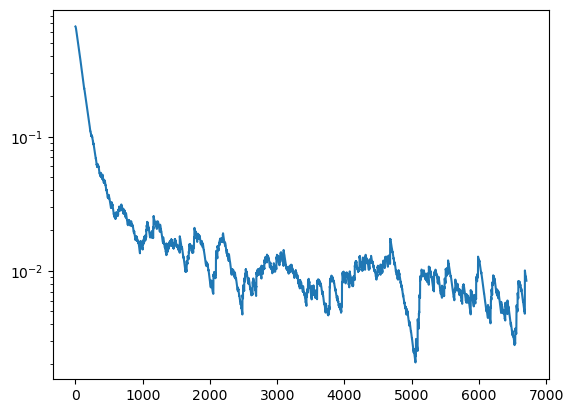

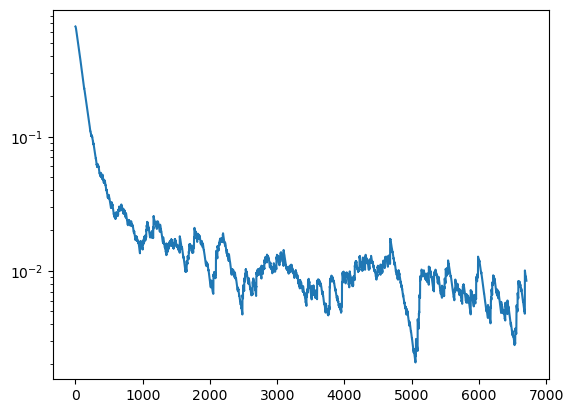

In [9]:
# 6 Training 


standard_classifier.train()

def standard_train_step(x,y):
    x = torch.from_numpy(x).float().to('cuda')
    y = torch.from_numpy(y).float().to('cuda')

    #Clear the gradient
    optimizer.zero_grad()

    #feed the images
    logits = standard_classifier(x)

    # Compute the loss
    loss = loss_fn(logits,y)

    # backward propogation
    loss.backward()
    optimizer.step()
    return loss 

# Training Loop
for epoch in range(params['num_epochs']):
    for idx in (range (loader.get_train_size() // params['batch_size'])):
        # grab a batch and propogate through the network
        x,y = loader.get_batch(params['batch_size'])
        loss = standard_train_step(x,y)
        loss_value = loss.detach().cpu().numpy()

        #Record the loss and plot
        loss_history.append(loss_value)
        plotter.plot(loss_history.get())



# Evaluation of Standard CNN 

In [10]:
# set the model to eval mode
standard_classifier.eval()

#Training Data
#Evaluate on a subset of CelebA + Imagenet

(batch_x,batch_y) = loader.get_batch(5000)

batch_x = torch.from_numpy(batch_x).float().to('cuda')
batch_y = torch.from_numpy(batch_y).float().to('cuda')

with torch.inference_mode():
    y_pred_logits = standard_classifier(batch_x)

    y_pred_standard = torch.round(torch.sigmoid(y_pred_logits))
    acc_standard = torch.mean((batch_y == y_pred_standard).float())

print(
    f" Standard CNN accuracy on potentially biased training set {acc_standard:.2f}"
)

 Standard CNN accuracy on potentially biased training set 1.00


4


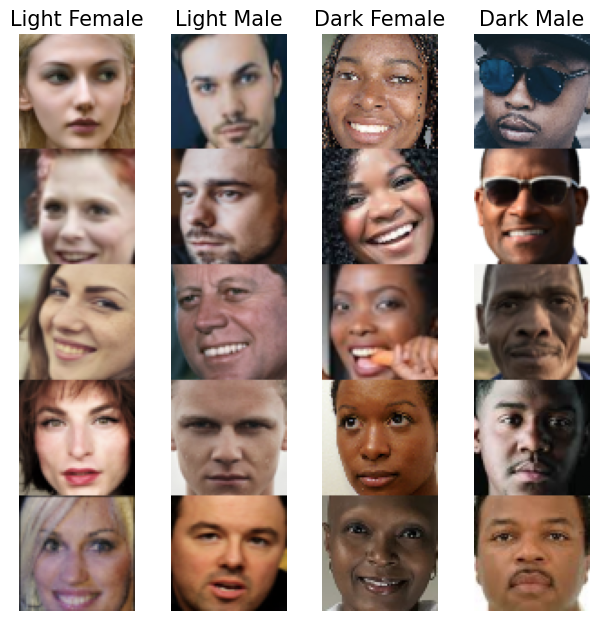

In [11]:
# Testing the model on unseen dataset

test_faces = mdl.lab2.get_test_faces(channels_last=channels_last)
# This will return a group of images
keys = ['Light Female', 'Light Male', 'Dark Female', 'Dark Male']
print(len(test_faces))


fig, axs = plt.subplots(1, len(keys), figsize=(7.5,7.5))
for i, (group,key) in enumerate(zip(test_faces,keys)):
    axs[i].imshow(np.hstack(group).transpose(1,2,0))
    axs[i].set_title(key,fontsize=15)
    axs[i].axis('off')



for i, group in enumerate(test_faces):
    print(f"Group {i} has {len(group)} images")
    print(f"Shape of first image in group {i}: {group[0].shape}")
    print()


print("Pixel values of first image in first group:")
one_imgage = test_faces[0][0].transpose(1,2,0)
plt.imshow(one_imgage)


Text(0.5, 1.0, 'Standard classifier predictions')

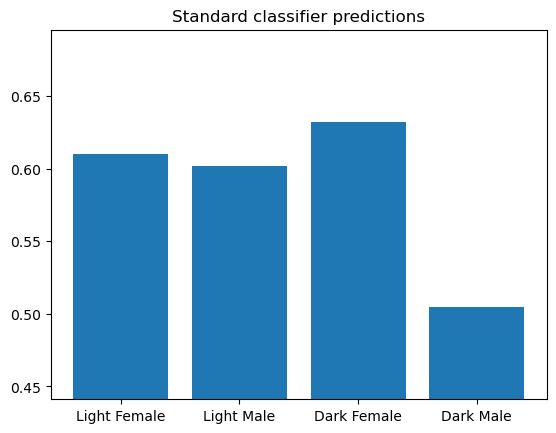

In [12]:
## Evaluate the Standard CNN of test data 

standard_classifier_probs_list = []

with torch.inference_mode():
    for x in test_faces:
        x = torch.from_numpy(np.array(x,dtype=np.float32)).to('cuda')
        logits = standard_classifier(x)
        probs = torch.sigmoid(logits)
        probs = torch.squeeze(probs, dim=-1)
        standard_classifier_probs_list.append(probs.cpu().numpy())

standard_classifier_probs = np.stack(standard_classifier_probs_list, axis=0)

#plot the prediction accuracie per demographic

xx = range(len(keys))
yy = standard_classifier_probs.mean(axis=1)
plt.bar(xx,yy)
plt.xticks(xx, keys)
plt.ylim(max(0, yy.min() - np.ptp(yy) / 2.0), yy.max() + np.ptp(yy) / 2.0)
plt.title("Standard classifier predictions")



# Variational Autoencoders (VAEs)
- It rely on an encoder-decoder structure to learn the latent representation of the input data.
- The encoders process is as follow:  
     - The encoder network takes the input image
     - Encode the image into a seriese of variables defined by a mean and standard deviations (σ).
     - From the distribution of these parameters it  generates a set of latent variables.
     - The decoder network then decodes these variables to generate a reconstruction of the original image.  
- **Latent Space**  is a compressed, lower-dimensional representation of high-dimensional data, capturing its essential features and relationships

# VAEs Loss Function:
We have two terms in our VAE Loss Function:
1. **Latent loss($L_{KL}$)**: Kullback-Leibler (KL) divergence defines how closely the latent variable matche a unit Gaussian.
2. **Reconstruction loss ($ L_{x}(x, \hat{x}) $)**: measures how accurately the reconstructed outputs match the input and is given by the $L^1$ norm of the input image and its reconstruted output.

The equation for the loss function is provided by:

$$ L_{KL}(\mu , \sigma) = \frac{1}{2}\sum_{j=0}^{k-1} (\sigma_j + \mu_j^2 - 1 - \log {\sigma_j}) 
$$

$\mu$ : mean value for each latent dimension, it controls the center      

$\sigma (or  ~ log ~ o^2) $: means variance or spread for each latent dimensions    
The KL term in the loss measures how far your learned distribution N(μ, σ²) is from the target N(0, I).



The equation for the reconstruciton loss is provided by:
$$
 Lx(x , \hat{x}) = ||x - \hat{x}||_1
 $$

 Thus for **VAE** Loss we have:
$$
 L_{VAE} = c.L_{KL} + L_x(x, \hat{x})
 $$

 where c is a weighting coefficient used for regualarization. Now we are ready to define our VAE loss function:

In [13]:
# Lets Define the Loss Function>

def vae_loss_function(x,x_recon,mu, logsigma,kl_weight=0.0005):
    #Lets calculate the latent loss
    # logsigma is the varience in logspace so we need to exponentiate it to get the actual variance
    sigma = torch.exp(logsigma) # this will give us the sigma from logsigma ,actual variance
    latent_loss  = 0.5 * torch.sum(sigma + mu.pow(2) -1- logsigma,  dim=1)

    # Reconstruction Loss

    reconstruction_loss = torch.mean(torch.abs(x-x_recon), dim = (1,2,3))

    # Now lets compute the VAE loss
    vae_loss = kl_weight * latent_loss + reconstruction_loss

    return vae_loss


# Understanding the Reparameterization
$$
 z= μ + e(\frac{1}{2} . logΣ) ∘ϵ
 $$    
 since log Σ means  log variance i.e. log σ²     
 where as $\mu$ is the `mean`    
Multiplying by ½ inside the `exp` is equivalent to taking the square root:

$$
e^{0.5 \cdot \log \sigma^2} = e^{\log \sigma} = \sigma
$$

so that you get the standard deviation **σ**.

**ε** is sampled from a standard normal distribution:

$$
\mathcal{N}(0, I)
$$


In [14]:
# VAE Reparameterization 
def sampling (z_mean,z_logsigma):
    eps = torch.randn_like(z_mean) # it creates a new tensor of the same shape and on same device
    # Fills it with random numbers sampled from a standard normal distribution 
    # 𝑁 (0,1): Mean = 0 , Standard deviation = 1
    z = z_mean + eps * torch.exp(z_logsigma) # Reparameterization trick
    return z


# Debiasing Variational Autoencoders (DB-VAE)
We have earlier trained our model for face detection on **CelebA** dataset which is biased. 
Now we will train our DB-VAE model on the facial detection task and run the debiasing operation during training evaluate on the PPB dataset, and compare its accuracy to our original, biased CNN Model.    
The key idea behind the debiasing is latent variables.

# Defining DB-VAE Loss Function
For face images our loss function will have two components:
1. **VAE loss($L_{VAE}$)**: Consists of the latenet loss and reconstruction loss.
2. **Classification loss($L_y(y,\hat{y})$):** standard cross-entroy loss for a binary classification problem    
In contrast, for images of non-faces our loss functions is solely the classification loss.    

We can write a single expression for the loss by defining an indicator variable ${I}_f$ which reflects which training data are images of faces ($I_f(y) = 1 $) and which are images of non-faces($I_f(y) = 0 $). Using this, we obtain    

$$L_total = L_y(y,\hat y) + I_f(y) \big [ L_{VAE}] $$





In [15]:
## Loss Function for DB-VAE 

def debiasing_loss_function (x,x_pred,y, y_logit, mu, logsigma):
    vae_loss = vae_loss_function(x,x_pred, mu, logsigma)

    classification_loss = F.binary_cross_entropy_with_logits(y_logit, y)

    y = y.float()
    face_indicator = (y == 1.0).float()

    total_loss = torch.mean(classification_loss + face_indicator * vae_loss)

    return total_loss, classification_loss


# Define the Decoder Portion of DB-VAE

In [16]:
n_filters = 12
latent_dim = 100


def make_face_decoder_network(latent_dim = 100,n_filters=12):
    class FaceDecoder(nn.Module):
        def __init__(self, latent_dim , n_filters):
            super(). __init__()

            self.latent_dim = latent_dim
            self.n_filters = n_filters


             # Linear (fully connected) layer to project from latent space
            # to a 4 x 4 feature map with (6*n_filters) channels
            self.linear = nn.Sequential(
                nn.Linear(latent_dim, 4 * 4 * 6 * n_filters), nn.ReLU()
            )

            # Convolutional upsampling (inverse of an encoder)
            self.deconv = nn.Sequential(
                # [B, 6n_filters, 4, 4] -> [B, 4n_filters, 8, 8]
                nn.ConvTranspose2d(
                    in_channels=6 * n_filters,
                    out_channels=4 * n_filters,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                nn.ReLU(),
                # [B, 4n_filters, 8, 8] -> [B, 2n_filters, 16, 16]
                nn.ConvTranspose2d(
                    in_channels=4 * n_filters,
                    out_channels=2 * n_filters,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                nn.ReLU(),
                # [B, 2n_filters, 16, 16] -> [B, n_filters, 32, 32]
                nn.ConvTranspose2d(
                    in_channels=2 * n_filters,
                    out_channels=n_filters,
                    kernel_size=5,
                    stride=2,
                    padding=2,
                    output_padding=1,
                ),
                nn.ReLU(),
                # [B, n_filters, 32, 32] -> [B, 3, 64, 64]
                nn.ConvTranspose2d(
                    in_channels=n_filters,
                    out_channels=3,
                    kernel_size=5,
                    stride=2,
                    padding=2,
                    output_padding=1,
                ),
            )

        def forward(self, z):
            """
            Forward pass of the decoder.

            Args:
                z (Tensor): Latent codes of shape [batch_size, latent_dim].

            Returns:
                Tensor of shape [batch_size, 3, 64, 64], representing
                the reconstructed images.
            """
            x = self.linear(z)  # [B, 4*4*6*n_filters]
            x = x.view(-1, 6 * self.n_filters, 4, 4)  # [B, 6n_filters, 4, 4]

            # Upsample through transposed convolutions
            x = self.deconv(x)  # [B, 3, 64, 64]
            return x

    return FaceDecoder(latent_dim, n_filters)



            

# Putting Together Decoder & Standard CNN Classifier


Lets define the core VAE architecture by subclassing nn.Module class; defining encoding, reparameterization, and decoding operatons; and calling the network end-to-end.

In [17]:
class DB_VAE(nn.Module):
    def __init__(self, latent_dim=100):
        super(). __init__()
        self.latent_dim = latent_dim

        #Define the number of outputs for the encoder
        self.encoder = make_standard_classifier(n_outputs=2 * latent_dim +1 )
        self.decoder = make_face_decoder_network()

    # function to feed images into encoder, encode the latent space, and output

    def encode(self, x):
        encoder_output = self.encoder(x)

        #Classification prediction
        y_logit = encoder_output[: , 0].unsqueeze(-1)

        #latent variable distribution parameters
        z_mean = encoder_output[: , 1 : self.latent_dim + 1]
        z_logsigma = encoder_output [: , self.latent_dim+1 :]
        return y_logit,z_mean,z_logsigma
    
    #VAE reparameterizaiton: given a mean and logsigma, sample latent variables

    def reparameterize(self,z_mean,z_logsigma):
        z = sampling(z_mean, z_logsigma)
        return z
    # Decode the latenet space and out reconstruction
    def decode(self,z):
        reconstruction = self.decoder(z)
        return reconstruction
    
    # The forward function will be used to pass inputs x through the core VAE
    def forward(self,x):
        # Encode input to a prediction and latent space
        y_logit, z_mean, z_logsigma = self.encode(x)

        #reparameterization
        z = self.reparameterize(z_mean,z_logsigma)

        # Reconstruction
        recon  = self.decode(z)
        return y_logit,z_mean,z_logsigma, recon
    
    # predict face or not face logit for given input x

    def predict(self, x):
        # Encode input to a prediction and latent space
        y_logit,z_mean, z_logsigma = self.encode(x)
        return y_logit
    
dbvae = DB_VAE(latent_dim)


# Adaptive resampling for automated debiasing with DB-VAE


In [18]:
def get_latent_mu(images, dbvae, batch_size=64):
    dbvae.eval()
    all_z_mean = []

    # if images is NumPy, convert once outside the loop

    images_t = torch.from_numpy(images).float()

    with torch.inference_mode():
        for start in range(0,len(images_t), batch_size):
            end = start + batch_size
            batch = images_t[start:end]
            batch = batch.to('cuda').permute(0,3,1,2)

            #forward pass on this chunk only

            _, z_mean,_,_ = dbvae(batch)
            all_z_mean.append(z_mean.cpu())

    # concatenate all partial z_mean
    z_mean_full = torch.cat(all_z_mean, dim=0) # shape [N, latent_dim]
    mu = z_mean_full.numpy()
    return mu

In [19]:
### Resampling algorithm for DB-VAE ###

"""Function that recomputes the sampling probabilities for images within a batch
      based on how they distribute across the training data"""
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001):
    print("Recomputing the sampling probabilities")

    # TODO: run the input batch and get the latent variable means
    mu = get_latent_mu(images, dbvae) # TODO

    # sampling probabilities for the images
    training_sample_p = np.zeros(mu.shape[0], dtype=np.float64)

    # consider the distribution for each latent variable
    for i in range(latent_dim):
        latent_distribution = mu[:, i]
        # generate a histogram of the latent distribution
        hist_density, bin_edges = np.histogram(
            latent_distribution, density=True, bins=bins
        )

        # find which latent bin every data sample falls in
        bin_edges[0] = -float("inf")
        bin_edges[-1] = float("inf")

        # TODO: call the digitize function to find which bins in the latent distribution
        #    every data sample falls in to
        # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.digitize.html
        bin_idx = np.digitize(latent_distribution, bin_edges)  # determine bin indices for each sample

        # smooth the density function
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        # invert the density function
        p = 1.0 / (hist_smoothed_density[bin_idx - 1])

        # normalize all probabilities
        p = p / np.sum(p)

        # update sampling probabilities by taking element-wise maximum
        # so samples that are rare in any latent dimension get higher probability
        training_sample_p = np.maximum(training_sample_p, p)

    # final normalization
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

Starting epoch 10/10
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

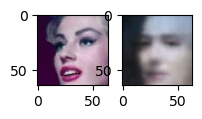

 14%|█▍        | 497/3434 [00:04<00:26, 110.83it/s]

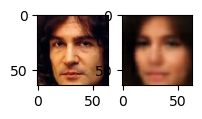

 29%|██▉       | 998/3434 [00:09<00:22, 107.03it/s]

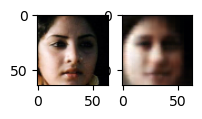

 44%|████▎     | 1494/3434 [00:13<00:18, 106.28it/s]

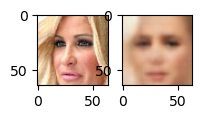

 58%|█████▊    | 1991/3434 [00:18<00:13, 104.69it/s]

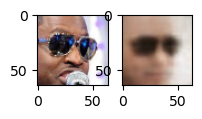

 73%|███████▎  | 2500/3434 [00:23<00:08, 106.76it/s]

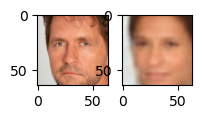

 87%|████████▋ | 2998/3434 [00:28<00:04, 108.89it/s]

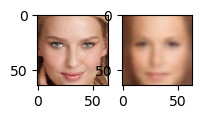

100%|██████████| 3434/3434 [00:32<00:00, 106.76it/s]


In [22]:
### Training the DB-VAE ###

# Hyperparameters
params = dict(
    batch_size=32,
    learning_rate=5e-4,
    latent_dim=100,
    num_epochs=10,  # DB-VAE needs slightly more epochs to train
)

#experiment = create_experiment("6S191_Lab2_Part2_DBVAE", params)

# instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(params["latent_dim"]).to('cuda')
optimizer = optim.Adam(dbvae.parameters(), lr=params["learning_rate"])


def debiasing_train_step(x, y):
    optimizer.zero_grad()

    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)

    # call the DB_VAE loss function to compute the loss
    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

    loss.backward()
    optimizer.step()

    return loss


# get training faces from data loader
all_faces = loader.get_all_train_faces()

# The training loop -- outer loop iterates over the number of epochs
step = 0
for i in range(params["num_epochs"]):
    IPython.display.clear_output(wait=True)
    print("Starting epoch {}/{}".format(i + 1, params["num_epochs"]))

    # Recompute data sampling proabilities
    """Recompute the sampling probabilities for debiasing"""
    p_faces = get_training_sample_probabilities(all_faces, dbvae)

    # get a batch of training data and compute the training step
    for j in tqdm.tqdm(range(loader.get_train_size() // params["batch_size"])):
        # load a batch of data
        (x, y) = loader.get_batch(params["batch_size"], p_pos=p_faces)
        x = torch.from_numpy(x).float().to('cuda')
        y = torch.from_numpy(y).float().to('cuda')

        # loss optimization
        loss = debiasing_train_step(x, y)
        loss_value = loss.detach().cpu().numpy()
       # experiment.log_metric("loss", loss_value, step=step)

        # plot the progress every 200 steps
        if j % 500 == 0:
            mdl.util.plot_sample(x, y, dbvae, backend="pt")

        step += 1

#experiment.end()

# Evaluation of DB - VAE on Test Dataset

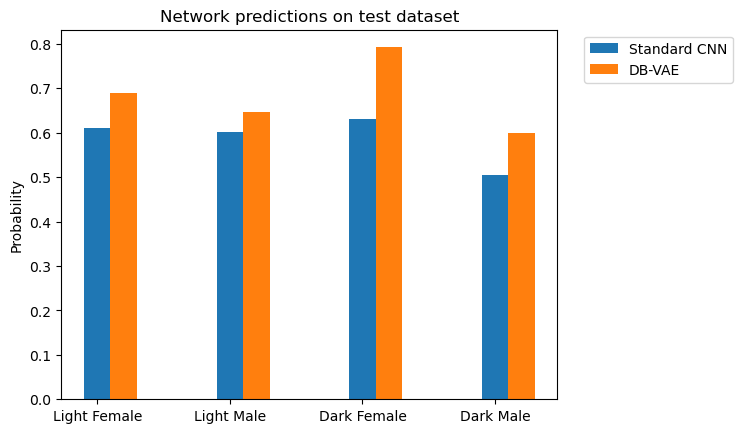

In [21]:
dbvae.to('cuda')
dbvae_logits_list = []
for face in test_faces:
    face = np.asarray(face, dtype=np.float32)
    face = torch.from_numpy(face).to('cuda')

    # Forward pass to get the classification logit
    with torch.inference_mode():
        logit = dbvae.predict(face)

    dbvae_logits_list.append(logit.detach().cpu().numpy())

dbvae_logits_array = np.concatenate(dbvae_logits_list, axis=0)
dbvae_logits_tensor = torch.from_numpy(dbvae_logits_array)
dbvae_probs_tensor = torch.sigmoid(dbvae_logits_tensor)
dbvae_probs_array = dbvae_probs_tensor.squeeze(dim=-1).numpy()

xx = np.arange(len(keys))

std_probs_mean = standard_classifier_probs.mean(axis=1)
dbvae_probs_mean = dbvae_probs_array.reshape(len(keys), -1).mean(axis=1)

plt.bar(xx, std_probs_mean, width=0.2, label="Standard CNN")
plt.bar(xx + 0.2, dbvae_probs_mean, width=0.2, label="DB-VAE")

plt.xticks(xx, keys)
plt.title("Network predictions on test dataset")
plt.ylabel("Probability")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()